<a href="https://colab.research.google.com/github/tahmidjamal12/231N_Final_Code/blob/main/sam/evaluation_sam/sam_eval1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q opencv-python h5py scikit-learn tqdm

  Preparing metadata (setup.py) ... done


In [ ]:
import h5py
import numpy as np

# Open the HDF5 file
with h5py.File('/content/drive/MyDrive/sam_eval/dataset/annotation/1048806_annotation.hdf5', 'r') as f:

    # Print the keys (top-level groups/datasets)
    print("Keys in the HDF5 file:")
    print(list(f.keys()))
    print(f['segments'])

Keys in the HDF5 file:
['segments']
<HDF5 group "/segments" (3 members)>


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 0) Mount Drive (if not already done) and install dependencies
# ─────────────────────────────────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

# If SAM is not installed yet, run:
# !pip install git+https://github.com/facebookresearch/segment-anything.git
# !pip install h5py opencv-python matplotlib tqdm scipy

# ─────────────────────────────────────────────────────────────────────────────
# 1) Imports
# ─────────────────────────────────────────────────────────────────────────────
import os
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment

import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# ─────────────────────────────────────────────────────────────────────────────
# 2) Paths and SAM Setup
# ─────────────────────────────────────────────────────────────────────────────
base_path = "/content/drive/MyDrive/sam_eval"
checkpoint_path = f"{base_path}/checkpoints/sam_vit_h_4b8939.pth"

# Load SAM (ViT-H) onto GPU
sam = sam_model_registry["vit_h"](checkpoint=checkpoint_path).to("cuda")
mask_generator = SamAutomaticMaskGenerator(sam)

# Directories for images, HDF5 annotations, and where to write results
image_dir = f"{base_path}/dataset/images"
anno_dir  = f"{base_path}/dataset/annotation"

# HDF5 file where we will dump (RGB, GT masks, SAM masks) for each image
output_h5 = f"{base_path}/results/sam_results.h5"
os.makedirs(os.path.dirname(output_h5), exist_ok=True)

# Visualization output folder (for plot_segments_autoseg)
vis_folder = f"{base_path}/results/vis_sam"
os.makedirs(vis_folder, exist_ok=True)

# Gather sorted list of image IDs (filename minus "_rgb.png")
image_ids = [fname[:-8] for fname in os.listdir(image_dir) if fname.endswith("_rgb.png")]
image_ids.sort()

# ─────────────────────────────────────────────────────────────────────────────
# 3) IoU and AP/AR functions (exactly as in evaluate_autoseg.py)
# ─────────────────────────────────────────────────────────────────────────────
def batched_iou(x, y=None):
    """
    x: (N_gt, H, W) binary masks
    y: (N_pred, H, W) binary masks (if None, uses x for self-IoU)
    returns: (N_gt, N_pred) IoU matrix
    """
    if y is None:
        y = x
    xp = x[:, None]      # shape (N_gt, 1, H, W)
    yp = y[None]         # shape (1, N_pred, H, W)
    intersection = (xp & yp).sum(axis=(-1, -2))
    union = (xp | yp).sum(axis=(-1, -2))
    # Avoid division by zero: whenever union == 0, set union = 1 so IoU = 0
    union = np.where(union == 0, 1, union)
    return intersection / union

def evaluate_AP_AR_single_image(pred_segments, gt_segments):
    """
    pred_segments: (N_pred, H, W) binary masks
    gt_segments:   (N_gt,   H, W) binary masks
    Returns a dict with:
      'AP': float, 'AR': float,
      'assignments': [gt_inds, pred_inds],
      'iou_mat': np.array((N_gt, N_pred)),
      'thresholds': np.array of IoU thresholds.
    """
    iou_mat = batched_iou(gt_segments, pred_segments)  # shape (N_gt, N_pred)
    gt_inds, pred_inds = linear_sum_assignment(1.0 - iou_mat)
    ious = iou_mat[gt_inds, pred_inds]

    num_gt   = gt_segments.shape[0]
    num_pred = pred_segments.shape[0]

    precisions = []
    recalls    = []
    thresholds = np.arange(start=0.50, stop=0.95, step=0.05)

    for t in thresholds:
        tp = np.count_nonzero(ious >= t)
        precisions.append(tp / num_pred if num_pred > 0 else 0.0)
        recalls.append(tp / num_gt   if num_gt   > 0 else 0.0)

    return {
        'AP': np.mean(precisions),
        'AR': np.mean(recalls),
        'assignments': [gt_inds, pred_inds],
        'iou_mat': iou_mat,
        'thresholds': thresholds
    }

# ─────────────────────────────────────────────────────────────────────────────
# 4) plot_segments_autoseg (exactly as you provided)
# ─────────────────────────────────────────────────────────────────────────────
import matplotlib
def plot_segments_autoseg(data_path: str, out_dir: str):
    """
    Reads an HDF5 file with groups:
      img0/, img1/, ..., each containing:
        image_rgb     (H, W, 3)
        segments_gt   (n_gt, H, W)
        segments_pred (n_pred, H, W)
    For each image group, it makes a single PNG showing:
      Row 1: RGB image
      Row 2: GT masks (one column per GT)
      Row 3: Predicted masks (aligned to GT)
    Saves to out_dir/<idx>.png
    """
    with h5py.File(data_path, 'r') as f:
        for idx, img_key in enumerate(f.keys()):
            img_group = f[img_key]
            rgb       = img_group['image_rgb'][:]        # (H, W, 3)
            gt_masks  = img_group['segments_gt'][:]      # (n_gt, H, W)
            pred_masks= img_group['segments_pred'][:].astype(np.uint8)  # (n_pred, H, W)

            # Compute assignments via AP/AR helper
            assignments = evaluate_AP_AR_single_image(pred_masks, gt_masks)['assignments']
            gt_inds, pred_inds = assignments
            n_gt = gt_masks.shape[0]

            # Create a 3×n_gt grid
            fig, axes = plt.subplots(3, n_gt, figsize=(4 * n_gt, 12))
            if n_gt == 1:
                axes = axes.reshape(3, 1)

            for i in range(n_gt):
                # Row 1: RGB image
                axes[0, i].imshow(rgb)
                axes[0, i].set_title("RGB Image")
                axes[0, i].axis('off')

                # Row 2: GT mask i
                axes[1, i].imshow(gt_masks[i], cmap='gray')
                axes[1, i].set_title("GT Segment")
                axes[1, i].axis('off')

                # Row 3: corresponding predicted mask (if matched)
                if i in gt_inds:
                    vis_idx = np.where(gt_inds == i)[0][0]
                    pred_idx = pred_inds[vis_idx]
                    axes[2, i].imshow(pred_masks[pred_idx], cmap='gray')
                axes[2, i].set_title("Predicted Segment")
                axes[2, i].axis('off')

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            out_file = os.path.join(out_dir, f"{idx}.png")
            fig.savefig(out_file, bbox_inches='tight')
            plt.close(fig)
            print(f"Saved visualization to {out_file}")

# ─────────────────────────────────────────────────────────────────────────────
# 5) Build a new HDF5 ("sam_results.h5") containing:
#     /img0/
#       image_rgb     (H, W, 3)
#       segments_gt   (n_gt, H, W)
#       segments_pred (n_pred, H, W)
#     /img1/  ...
# ─────────────────────────────────────────────────────────────────────────────
with h5py.File(output_h5, 'w') as h5f:
    for idx, img_id in enumerate(tqdm(image_ids, desc="Writing SAM results to HDF5")):
        # 5.1 Load RGB image
        img_path = os.path.join(image_dir, f"{img_id}_rgb.png")
        img_bgr  = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        H, W = image_rgb.shape[:2]

        # 5.2 Load GT masks
        h5_path = os.path.join(anno_dir, f"{img_id}_annotation.hdf5")
        with h5py.File(h5_path, 'r') as hf:
            gt_group = hf['segments']
            gt_list = []
            for key in sorted(gt_group.keys(), key=lambda x: int(x)):
                arr = np.array(gt_group[key][:], dtype=np.uint8)
                gt_list.append((arr > 0).astype(np.uint8))
        if gt_list:
            gt_stack = np.stack(gt_list, axis=0)  # (n_gt, H, W)
        else:
            gt_stack = np.zeros((0, H, W), dtype=np.uint8)

        # ─────────────────────────────────────────────────────────────────────────────
        # 5.3  Run SAM once, keep TOP-50 masks, record IoU & stability
        # ─────────────────────────────────────────────────────────────────────────────
        sam_outputs = mask_generator.generate(image_rgb)

        # Sort masks by SAM’s predicted IoU (highest-quality first) …
        sam_outputs_sorted = sorted(
            sam_outputs,
            key=lambda m: m.get("predicted_iou", 0.0),
            reverse=True
        )

        # … and keep at most 50
        top50 = sam_outputs_sorted[:50]

        # Build arrays
        mask_list       = [m["segmentation"].astype(np.uint8) for m in top50]      # (M, H, W)
        iou_scores      = [m.get("predicted_iou", 0.0)       for m in top50]       # (M,)
        stability_scores= [m.get("stability_score", 0.0)     for m in top50]       # (M,)

        # Stack masks (or create empty placeholder if none)
        if mask_list:
            pred_stack = np.stack(mask_list, axis=0)           # shape (M, H, W)
        else:
            pred_stack = np.zeros((0, H, W), dtype=np.uint8)   # no masks found
            iou_scores = []
            stability_scores = []

        # ─────────────────────────────────────────────────────────────────────────────
        # 5.4  Create group “/img{idx}” and write all datasets
        # ─────────────────────────────────────────────────────────────────────────────
        grp = h5f.create_group(f"img{idx}")

        grp.create_dataset("image_rgb",              data=image_rgb,             compression="gzip")
        grp.create_dataset("segments_gt",            data=gt_stack,              compression="gzip")
        grp.create_dataset("segments_pred",          data=pred_stack,            compression="gzip")
        grp.create_dataset("segments_pred_iou",      data=np.array(iou_scores,      dtype=np.float32),
                          compression="gzip")
        grp.create_dataset("segments_pred_stability",data=np.array(stability_scores,dtype=np.float32),
                          compression="gzip")

    print(f"Done writing all images to '{output_h5}'")

# ─────────────────────────────────────────────────────────────────────────────
# 6) Use plot_segments_autoseg to save visualizations into vis_folder
# ─────────────────────────────────────────────────────────────────────────────
print("Generating visualizations from HDF5 ...")
plot_segments_autoseg(output_h5, vis_folder)

# ─────────────────────────────────────────────────────────────────────────────
# 7) Compute and print summary metrics (mean AP, mean AR, mean IoU)
# ─────────────────────────────────────────────────────────────────────────────
all_APs = []
all_ARs = []
all_IoU_vals = []

with h5py.File(output_h5, 'r') as f:
    for img_key in f.keys():
        img_grp = f[img_key]
        gt_stack   = img_grp['segments_gt'][:].astype(np.uint8)
        pred_stack = img_grp['segments_pred'][:].astype(np.uint8)

        res = evaluate_AP_AR_single_image(pred_stack, gt_stack)
        all_APs.append(res['AP'])
        all_ARs.append(res['AR'])

        # Extract matched IoUs from the IoU‐matrix
        iou_mat = res['iou_mat']
        if iou_mat.size > 0:
            gt_inds, pred_inds = linear_sum_assignment(1.0 - iou_mat)
            matched = iou_mat[gt_inds, pred_inds]
            all_IoU_vals.extend(matched.tolist())

mean_AP = np.mean(all_APs) if all_APs else 0.0
mean_AR = np.mean(all_ARs) if all_ARs else 0.0
mean_IoU = np.nanmean(all_IoU_vals) if all_IoU_vals else 0.0

print("\n=== FINAL SUMMARY METRICS ===")
print(f"Number of images: {len(image_ids)}")
print(f"Mean Average Precision (mAP):  {mean_AP:.4f}")
print(f"Mean Average Recall   (mAR):  {mean_AR:.4f}")
print(f"Mean IoU across matches:    {mean_IoU:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Writing SAM results to HDF5: 100%|██████████| 95/95 [12:02<00:00,  7.61s/it]


Done writing all images to '/content/drive/MyDrive/sam_eval/results/sam_results.h5'
Generating visualizations from HDF5 ...
Saved visualization to /content/drive/MyDrive/sam_eval/results/vis_sam/0.png
Saved visualization to /content/drive/MyDrive/sam_eval/results/vis_sam/1.png
Saved visualization to /content/drive/MyDrive/sam_eval/results/vis_sam/2.png
Saved visualization to /content/drive/MyDrive/sam_eval/results/vis_sam/3.png
Saved visualization to /content/drive/MyDrive/sam_eval/results/vis_sam/4.png
Saved visualization to /content/drive/MyDrive/sam_eval/results/vis_sam/5.png
Saved visualization to /content/drive/MyDrive/sam_eval/results/vis_sam/6.png
Saved visualization to /content/drive/MyDrive/sam_eval/results/vis_sam/7.png
Saved visualization to /content/drive/MyDrive/sam_eval/results/vis_sam/8.png
Saved visualization to /content/drive/MyDrive/sam_eval/results/vis_sam/9.png
Saved visualization to /content/drive/MyDrive/sam_eval/results/vis_sam/10.png
Saved visualization to /cont

In [ ]:
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from segment_anything import SamAutomaticMaskGenerator

# 1) Define grid of hyperparameters to try
pred_iou_thresh_list        = [0.94, 0.96, 0.98]
stability_score_thresh_list = [0.9,0.95]

results = []

# 2) Loop over every combination
for piou, sst in itertools.product(pred_iou_thresh_list, stability_score_thresh_list):
    print(f"\n=== Testing pred_iou_thresh={piou:.2f}, stability_score_thresh={sst:.2f} ===")

    # 2a) (re)build mask_generator with these thresholds
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=32,
        pred_iou_thresh=piou,
        stability_score_thresh=sst,
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=100,
    )

    all_APs    = []
    all_ARs    = []
    all_IoUs   = []

    # 3) Generate & evaluate on your whole eval set
    for img_id in tqdm(image_ids, desc="  images"):
        # load rgb, gt exactly as before...
        img_path = os.path.join(image_dir, f"{img_id}_rgb.png")
        img_bgr  = cv2.imread(img_path)
        rgb       = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # load your GT stack
        with h5py.File(os.path.join(anno_dir, f"{img_id}_annotation.hdf5"), 'r') as hf:
            gt_group = hf['segments']
            gt_stack = np.stack(
                [hf['segments'][k][:].astype(bool).astype(np.uint8)
                 for k in sorted(gt_group.keys(), key=int)],
                axis=0
            ) if len(gt_group) else np.zeros((0, *rgb.shape[:2]), np.uint8)

        # generate masks
        sam_out = mask_generator.generate(rgb)
        # convert top‐whatever → full stack (we keep *all* here)
        pred_stack = np.stack([m["segmentation"].astype(np.uint8) for m in sam_out], axis=0) \
                     if len(sam_out) else np.zeros((0, *rgb.shape[:2]), np.uint8)

        # evaluate
        res = evaluate_AP_AR_single_image(pred_stack, gt_stack)
        all_APs.append(res['AP'])
        all_ARs.append(res['AR'])

        # collect matched IoUs
        iou_mat = res['iou_mat']
        if iou_mat.size:
            gt_inds, pred_inds = linear_sum_assignment(1.0 - iou_mat)
            all_IoUs.extend(iou_mat[gt_inds, pred_inds].tolist())

    # 4) compute means
    mean_AP  = np.mean(all_APs)
    mean_AR  = np.mean(all_ARs)
    mean_IoU = np.mean(all_IoUs) if all_IoUs else 0.0

    print(f" → mAP={mean_AP:.4f}, mAR={mean_AR:.4f}, meanIoU={mean_IoU:.4f}")

    results.append({
        "pred_iou_thresh": piou,
        "stability_score_thresh": sst,
        "mAP": mean_AP,
        "mAR": mean_AR,
        "meanIoU": mean_IoU
    })

# 5) Summarize grid search
df = pd.DataFrame(results)
display(df.sort_values(by="mAP", ascending=False).reset_index(drop=True))



=== Testing pred_iou_thresh=0.94, stability_score_thresh=0.90 ===


  images: 100%|██████████| 95/95 [07:24<00:00,  4.68s/it]


 → mAP=0.0855, mAR=0.7207, meanIoU=0.7879

=== Testing pred_iou_thresh=0.94, stability_score_thresh=0.95 ===


  images: 100%|██████████| 95/95 [07:09<00:00,  4.52s/it]


 → mAP=0.0897, mAR=0.6952, meanIoU=0.7652

=== Testing pred_iou_thresh=0.96, stability_score_thresh=0.90 ===


  images: 100%|██████████| 95/95 [07:09<00:00,  4.52s/it]


 → mAP=0.1201, mAR=0.6936, meanIoU=0.7652

=== Testing pred_iou_thresh=0.96, stability_score_thresh=0.95 ===


  images: 100%|██████████| 95/95 [06:58<00:00,  4.41s/it]


 → mAP=0.1218, mAR=0.6645, meanIoU=0.7449

=== Testing pred_iou_thresh=0.98, stability_score_thresh=0.90 ===


  images: 100%|██████████| 95/95 [06:48<00:00,  4.30s/it]


 → mAP=0.1819, mAR=0.6099, meanIoU=0.6853

=== Testing pred_iou_thresh=0.98, stability_score_thresh=0.95 ===


  images: 100%|██████████| 95/95 [06:43<00:00,  4.24s/it]

 → mAP=0.1835, mAR=0.5990, meanIoU=0.6731


,pred_iou_thresh,stability_score_thresh,mAP,mAR,meanIoU
0,0.98,0.95,0.183493,0.599047,0.673128
1,0.98,0.90,0.181909,0.609916,0.685307
2,0.96,0.95,0.121814,0.664452,0.744936
3,0.96,0.90,0.120069,0.693577,0.765173
4,0.94,0.95,0.089731,0.695203,0.765178
5,0.94,0.90,0.085498,0.720702,0.787865


In [ ]:
%cd MyDrive/sam_eval/results/
!pwd

[Errno 2] No such file or directory: 'MyDrive/sam_eval/results/'
/content/drive/.shortcut-targets-by-id/1TkGNfiPiYZ6IIA9l9g3-JL1J49XbhYaP/sam_eval/results
/content/drive/.shortcut-targets-by-id/1TkGNfiPiYZ6IIA9l9g3-JL1J49XbhYaP/sam_eval/results


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def inspect_h5(file_path):
    """
    Open an HDF5 file, list its structure, and display the first mask if one exists.
    """
    try:
        with h5py.File(file_path, "r") as f:
            print(f"Opened file: {file_path}\n")

            # 1) List top‐level groups/datasets
            print("Top-level keys:")
            for key in f.keys():
                print(f"  - {key}")

            # 2) For each group, list its children (and shape/dtype)
            for key in f.keys():
                item = f[key]
                if isinstance(item, h5py.Group):
                    print(f"\nGroup '{key}' contains:")
                    for subkey in item.keys():
                        dset = item[subkey]
                        print(f"    - {subkey}  (shape: {dset.shape}, dtype: {dset.dtype})")
                else:
                    print(f"\nDataset '{key}': shape = {item.shape}, dtype = {item.dtype}")

            # 3) If there is a dataset literally named "masks", plot the first one:
            if "masks" in f:
                masks = f["masks"][:]
                if masks.ndim >= 2:
                    first_mask = masks[0]
                    plt.figure(figsize=(4,4))
                    plt.imshow(first_mask, cmap="gray")
                    plt.title("First Mask")
                    plt.axis("off")
                    plt.show()
                else:
                    print("\n'Masks' dataset exists but does not have 2+ dims.")
            else:
                print("\nNo 'masks' dataset found at top level.")

    except FileNotFoundError:
        print(f"Error: File not found → {file_path}")
    except OSError as e:
        print(f"Error opening file: {e}")

# ── UPDATE this path to wherever your sam_result.h5 actually is: ──
# If you uploaded directly via Colab’s Files pane, it’s probably:
#     "/content/sam_result.h5"
# If you mounted Drive, it might be:
#     "/content/drive/MyDrive/<your-folder>/sam_result.h5"
file_path = "/content/drive/MyDrive/sam_eval/results/sam_results.h5"

inspect_h5(file_path)


Opened file: /content/drive/MyDrive/sam_eval/results/sam_results.h5

Top-level keys:
  - img0
  - img1
  - img10
  - img11
  - img12
  - img13
  - img14
  - img15
  - img16
  - img17
  - img18
  - img19
  - img2
  - img20
  - img21
  - img22
  - img23
  - img24
  - img25
  - img26
  - img27
  - img28
  - img29
  - img3
  - img30
  - img31
  - img32
  - img33
  - img34
  - img35
  - img36
  - img37
  - img38
  - img39
  - img4
  - img40
  - img41
  - img42
  - img43
  - img44
  - img45
  - img46
  - img47
  - img48
  - img49
  - img5
  - img50
  - img51
  - img52
  - img53
  - img54
  - img55
  - img56
  - img57
  - img58
  - img59
  - img6
  - img60
  - img61
  - img62
  - img63
  - img64
  - img65
  - img66
  - img67
  - img68
  - img69
  - img7
  - img70
  - img71
  - img72
  - img73
  - img74
  - img75
  - img76
  - img77
  - img78
  - img79
  - img8
  - img80
  - img81
  - img82
  - img83
  - img84
  - img85
  - img86
  - img87
  - img88
  - img89
  - img9
  - img90
  - img91
  - i

## Getting SAM Visualizations

In [ ]:
# STEP 1: Imports
import os
import cv2
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from segment_anything import sam_model_registry, SamPredictor
from skimage.segmentation import find_boundaries
from PIL import Image

# STEP 2: Paths and Configuration
base_path = "/content/drive/MyDrive/sam_eval"
image_dir = f"{base_path}/dataset/images"
annotation_dir = f"{base_path}/dataset/annotation"
output_vis_dir = f"{base_path}/triplet_viz5"
os.makedirs(output_vis_dir, exist_ok=True)

# Load model
sam_checkpoint = f"{base_path}/checkpoints/sam_vit_h_4b8939.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)


In [ ]:
from scipy.ndimage import gaussian_filter

HIGH_CONTRAST_COLORS = [
    (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200),
    (245, 130, 48), (145, 30, 180), (70, 240, 240), (240, 50, 230),
    (210, 245, 60), (250, 190, 190), (0, 128, 128), (230, 190, 255),
    (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195),
    (0, 0, 128), (128, 128, 0), (255, 215, 180), (0, 0, 0)
]

def get_color(i):
    return np.array(HIGH_CONTRAST_COLORS[i % len(HIGH_CONTRAST_COLORS)], dtype=np.float32)

# === Improved Overlay ===
def overlay_segments(image, segments, alpha=0.7, blur_sigma=2.0):
    H, W = image.shape[:2]
    overlay = image.astype(np.float32).copy()
    used = np.zeros((H, W), dtype=bool)

    for i, mask in enumerate(segments):
        if mask.max() == 0:
            continue

        # Smooth mask edges
        mask = gaussian_filter(mask.astype(np.float32), sigma=blur_sigma)
        mask = np.clip(mask, 0, 1)
        mask = np.logical_and(mask > 0.05, ~used)  # remove overlap
        used = np.logical_or(used, mask)

        color = get_color(i).reshape(1, 1, 3)

        for c in range(3):
            overlay[..., c][mask] = (
                alpha * color[0, 0, c] + (1 - alpha) * overlay[..., c][mask]
            )

    return np.clip(overlay, 0, 255).astype(np.uint8)



In [ ]:
def run_sam_on_image(image_np, min_pixels=500):
    predictor.set_image(image_np)
    masks, scores, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        multimask_output=True
    )

    unique_masks = []
    used = np.zeros_like(masks[0])

    for i in np.argsort(-scores):
        mask = masks[i].astype(bool)
        if mask.sum() < min_pixels:
            continue
        if np.logical_and(mask, used).sum() / mask.sum() < 0.3:
            unique_masks.append(mask.astype(np.uint8))
            used = np.logical_or(used, mask)

    return np.stack(unique_masks) if unique_masks else masks.astype(np.uint8)


In [ ]:
def overlay_gt_segments(image, segments, alpha=0.5, blur_sigma=2.0):
    H, W = image.shape[:2]
    overlay = image.astype(np.float32).copy()

    for i, mask in enumerate(segments):
        if mask.max() == 0:
            continue

        # Smooth mask edges
        mask = gaussian_filter(mask.astype(np.float32), sigma=blur_sigma)
        mask = np.clip(mask, 0, 1)
        mask = mask > 0.05  # Keep soft edges, allow overlaps

        color = get_color(i).reshape(1, 1, 3)

        for c in range(3):
            overlay[..., c][mask] = (
                alpha * color[0, 0, c] + (1 - alpha) * overlay[..., c][mask]
            )

    return np.clip(overlay, 0, 255).astype(np.uint8)


In [ ]:
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith("_rgb.png")])

for fname in tqdm(image_files[:100]):
    image_id = fname.replace("_rgb.png", "")
    image_path = os.path.join(image_dir, fname)
    annotation_path = os.path.join(annotation_dir, f"{image_id}_annotation.hdf5")

    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load ground truth masks
    with h5py.File(annotation_path, 'r') as f:
        gt_masks = [f[f"segments/{k}"][:] for k in sorted(f["segments"].keys(), key=lambda x: int(x))]
    gt_masks = np.array(gt_masks)

    # Predict with SAM
    pred_masks = run_sam_on_image(image_rgb)

    # Visualize
    gt_overlay = overlay_gt_segments(image_rgb, gt_masks, alpha=0.5)
    pred_overlay = overlay_segments(image_rgb, pred_masks, alpha=0.5)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image")
    axes[1].imshow(gt_overlay)
    axes[1].set_title("Our Ground Truth Segments")
    axes[2].imshow(pred_overlay)
    axes[2].set_title("SAM GT Segments")

    for ax in axes:
        ax.axis('off')

    save_path = os.path.join(output_vis_dir, f"{image_id}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.close(fig)


100%|██████████| 95/95 [04:55<00:00,  3.11s/it]


Visualizing: img0


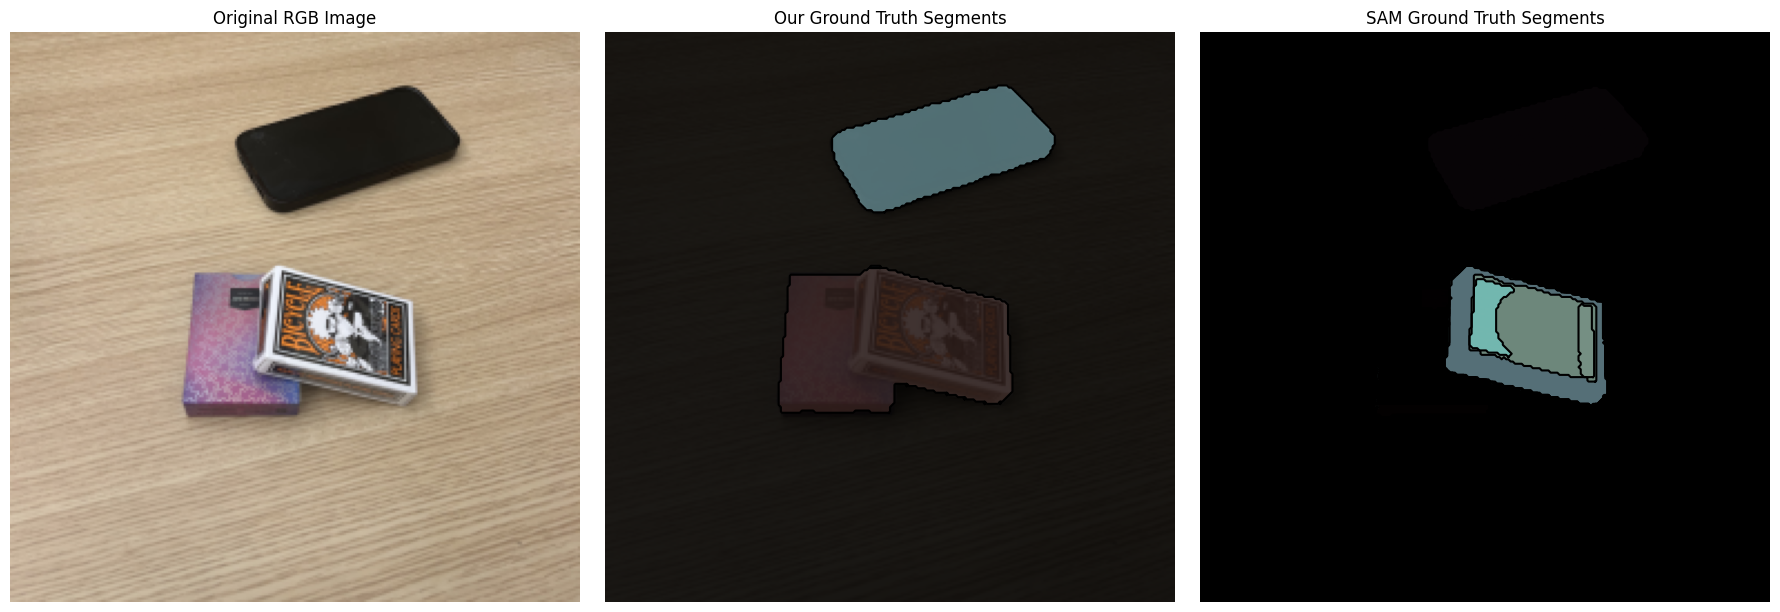

Visualizing: img1


KeyboardInterrupt: 

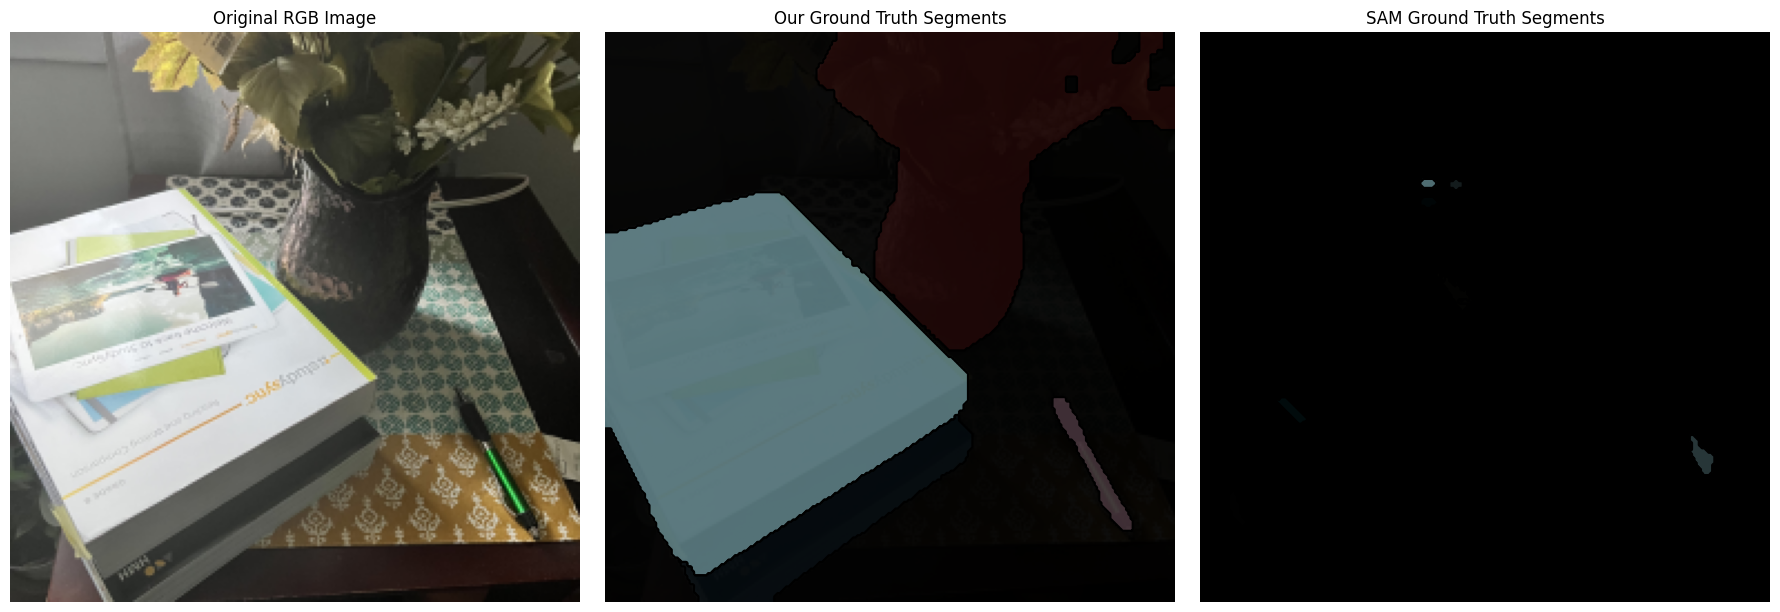

In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import find_contours
h5_file_path = os.path.join("/content/drive/MyDrive/sam_eval", "sam_results_with_score.h5")


# Helper: Generate distinct colors
def get_n_colors(n):
    cmap = plt.get_cmap('tab20', n)
    return [cmap(i)[:3] for i in range(n)]

# Helper: Draw masks on image with outline
def draw_segmentation(ax, image, masks, alpha=0.6):
    ax.imshow(image)
    colors = get_n_colors(len(masks))

    for i, mask in enumerate(masks):
        color = colors[i]
        # Build RGBA overlay with alpha only in mask
        overlay = np.zeros((*mask.shape, 4), dtype=np.float32)
        for j in range(3):
            overlay[:, :, j] = mask * color[j]
        overlay[:, :, 3] = mask * alpha  # Alpha channel only where mask==1

        ax.imshow(overlay)

        # Add contour outlines
        contours = find_contours(mask, 0.5)
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], color='black', linewidth=1.5)

    ax.axis('off')

# Replace with the path to your .h5 file (e.g., from uploaded file)
# Loop over images
from matplotlib.backends.backend_pdf import PdfPages
import os

# Output PDF path
pdf_path = "segment_visualizations.pdf"

with h5py.File(h5_file_path, 'r') as f, PdfPages(pdf_path) as pdf:
    for img_key in f.keys():
        group = f[img_key]
        print(f"Visualizing: {img_key}")

        image = group['image_rgb'][:]
        gt_masks = group['segments_gt'][:]  # (N, H, W)
        pred_masks = group['segments_pred'][:]  # (N, H, W)

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(image)
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].set_title("Our Ground Truth Segments")
        draw_segmentation(axs[1], image, gt_masks)

        axs[2].set_title("SAM Ground Truth Segments")
        draw_segmentation(axs[2], image, pred_masks)

        plt.tight_layout()
        pdf.savefig(fig)   # Save current figure to PDF
        plt.close(fig)     # Close figure to free memory


